In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt

In [2]:
# Seed
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [5]:
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Input_Output_Data_CNN_Features.mat')
df = pd.DataFrame({'F1':data1['F1'].ravel().round(2), 'F2':data1['F2'].ravel().round(2) ,'F3':data1['F3'].ravel().round(2),'F4':data1['F4'].ravel().round(2),
                   'F5':data1['F5'].ravel().round(2),'SS':data1['SS_Final'].ravel()})
df = df[['F1','F2','F3','F4','F5','SS']]

In [ ]:
# Preprocessing (SS)
arr = df.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132105, 300, 5)
Target shape (SS), Y =  (132105,)
After reshaping, X =  (132105, 1500)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train))
print("Validation samples:", np.shape(X_val))
print("Testing samples:", np.shape(x_test))

Training samples: (92473, 1500)
Validation samples: (13211, 1500)
Testing samples: (26421, 1500)


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(1500,),name='X_train')

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(512,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse']) # Use tf.keras.optimizers.Adam instead of tf.keras.optimizers.legacy.Adam
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ X_train (InputLayer)            │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       768,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 838,337 (3.20 MB)

 Trainable params: 838,337 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2888/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0190 - mse: 0.0190
Epoch 1: val_loss improved from inf to 0.01256, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 2/100
2886/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mse: 0.0041
Epoch 2: val_loss improved from 0.01256 to 0.00420, saving model to /content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/100
2887/2890 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mse: 0.0034
Epoch 3: val_loss did not improve from 0.00420
2890/2890 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0

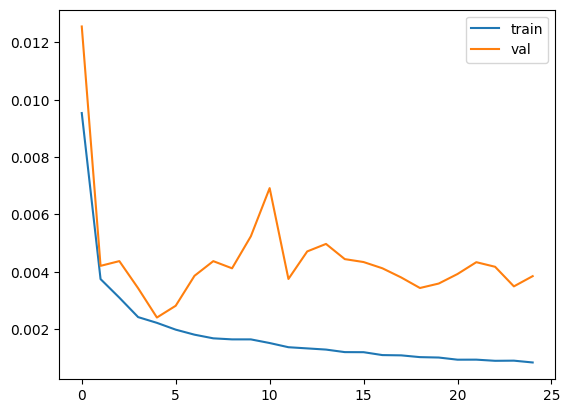

---Training time: 947.19477463 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
# The filepath should end with .keras or .h5
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Entire_Signal/Automatic_Features_Extraction/New_AFE_Models/MLP_Model_With_Extracted_Features/Check.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min') # Changed the file path here
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict(X_train)
y_predtrain_SS = np.array(y_predtrain)

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

# Model Performance: Validation
y_predval = model.predict(X_val)
y_predval_SS = np.array(y_predval)

val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

# Model Performance: Testing
y_predtest = model.predict(x_test)
y_predtest_SS =np.array(y_predtest)

test_r2_SS = r2_score(y_test_SS,y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f" %(train_r2_SS))
print("R2 scores: Validation (SS) - %0.5f" %(val_r2_SS))
print("R2 scores: Testing (SS) - %0.5f" %(test_r2_SS))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f" %(train_rmse_SS))
print("RMSE scores: Validation (SS) - %0.5f" %(val_rmse_SS))
print("RMSE scores: Testing (SS) - %0.5f" %(test_rmse_SS))

  66/2890 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X_train']
Received: inputs=Tensor(shape=(32, 1500))
  warnings.warn(msg)


2890/2890 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['X_train']
Received: inputs=Tensor(shape=(None, 1500))
  warnings.warn(msg)


413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R2 scores: Train (SS) - 0.97529
R2 scores: Validation (SS) - 0.89587
R2 scores: Testing (SS) - 0.73477
RMSE scores: Train (SS) - 0.02624
RMSE scores: Validation (SS) - 0.06200
RMSE scores: Testing (SS) - 0.09700


In [ ]:
# # Inverse scaling: SS
# Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
# Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
# y_test_SS = scaler_ss.inverse_transform(y_test_SS)
# y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
# y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
# y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# # Extract Data
# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

In [ ]:
# # Download Data
# # SS
# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>